In [1]:
import sys
sys.path.append('../src')
sys.path.append('../src/data/')
sys.path.append('../src/models/')
sys.path.append('../src/features/')
sys.path.append('../src/visualization/')
# will reload any library
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

print ("finished")

finished


In [2]:
# sportify specific
#from data.metrics import r_precision, cosine_sim_closest, cosine_sim_top, NDCG
from visualization.plot_utils import write_latex_table, summary_pooling_table,\
pooling_plots, pandas_settings, plot_settings,  save_result
# general
import pandas as pd
import numpy as np
from tqdm import tqdm
from features import AudioFeatures, TrackInfo, Popularity, GenreFeatures, Word2vecFeature
from collections import OrderedDict
import matplotlib.pyplot as plt
import seaborn as sns
# for bayesopt
import GPy
import GPyOpt
plot_settings()
pandas_settings()

def ranked_plots(pool,true,ranked,dist,f_name,r_type):
    sns.distplot([d for d,t in zip(dist,pool) if t in true],label='In playlist')
    sns.distplot([d for d,t in zip(dist,pool) if t not in true],label='Not in playlist')
    plt.ylabel('Normalized frequency')
    plt.xlabel('Distance')
    plt.title('{} with {}'.format(f_name,r_type))
    plt.legend()
    plt.show()
    true_rank = [i for i,t in enumerate(true)]
    estimated_rank = [i for i,t in enumerate(ranked) if t in true]
    
    plt.scatter(true_rank,estimated_rank)
    plt.plot([0, len(true)],[0, len(true)],'--',c='k',label='ideal')
    plt.xlabel('Real ranking')
    plt.ylabel('Estimated ranking')
    plt.title('{} with {}'.format(f_name,r_type))
    plt.show()
print ("FINISHED")

FINISHED


# Load track data and features

In [3]:
tracks = TrackInfo(subset='5k-')
print("loaded")

loaded


In [19]:
feats = [Word2vecFeature(w2v_type='track', logging=True),
        Word2vecFeature(w2v_type='track', logging=True),
        Word2vecFeature(w2v_type='track', logging=True),
        AudioFeatures(),
        Popularity()]


../data/w2v/track_w2v_model_1min_100dim IS LOADING
LOADED W2V
../data/w2v/track_w2v_model_1min_100dim IS LOADING
LOADED W2V
../data/w2v/track_w2v_model_1min_100dim IS LOADING
LOADED W2V
../data/interim/track_uri2popularity.pkl.bz2 IS LOADING...
LOADED POPULARITY


In [20]:
from data.metrics import r_precision, NDCG

def ranking_stats(pid,k,strat,n_pick,true_t,pool_t,true_a,pool_a):
    rp_t = r_precision(true_t,pool_t)
    ndgc_t = NDCG(true_t,pool_t)
    rp_a = r_precision(true_a,pool_a)
    ndgc_a = NDCG(true_a,pool_a)
    return OrderedDict([('pid',pid),('k',k),('strat',strat),('n',n_pick),
                        ('rprecision_tracks',rp_t),('rprecision_artist',rp_a),
                        ('NDCG_tracks',ndgc_t),('NDCG_artist',ndgc_a)])

print ("FINISHED")

FINISHED


# Test one playlist vs 1 feature

In [21]:
# select a feature
f = feats[0]
k=25
n_picks=5000
pid=194
strat='mean'
# rankign based on distances
turi_seed,auri_seed, turi_true,auri_true, turi_pool,auri_pool = tracks.get_playlist_pooltest(pid=pid,k=k,n=n_picks)
dist = f.distance_between_sets(turi_seed,turi_pool,strat)
sorted_indx=np.argsort(dist)
turi_ranked = [turi_pool[i] for i in sorted_indx]
auri_ranked = [auri_pool[i] for i in sorted_indx]
pd.DataFrame([ranking_stats(pid,k,strat,n_picks,turi_true,turi_pool,auri_true,auri_pool)])

,pid,k,strat,n,rprecision_tracks,rprecision_artist,NDCG_tracks,NDCG_artist
0,194,25,mean,5000,0.01,0.03,"2,202.92","4,709.51"


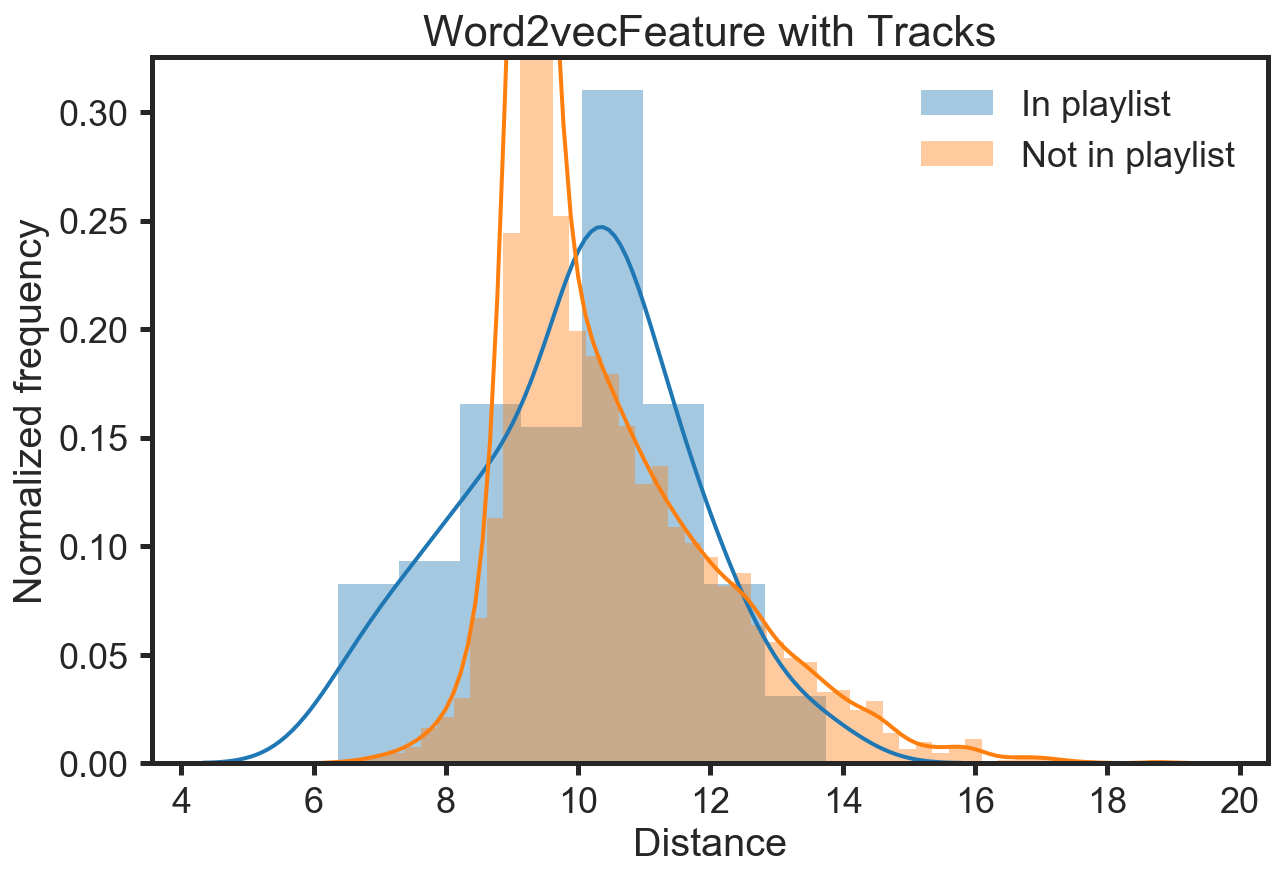

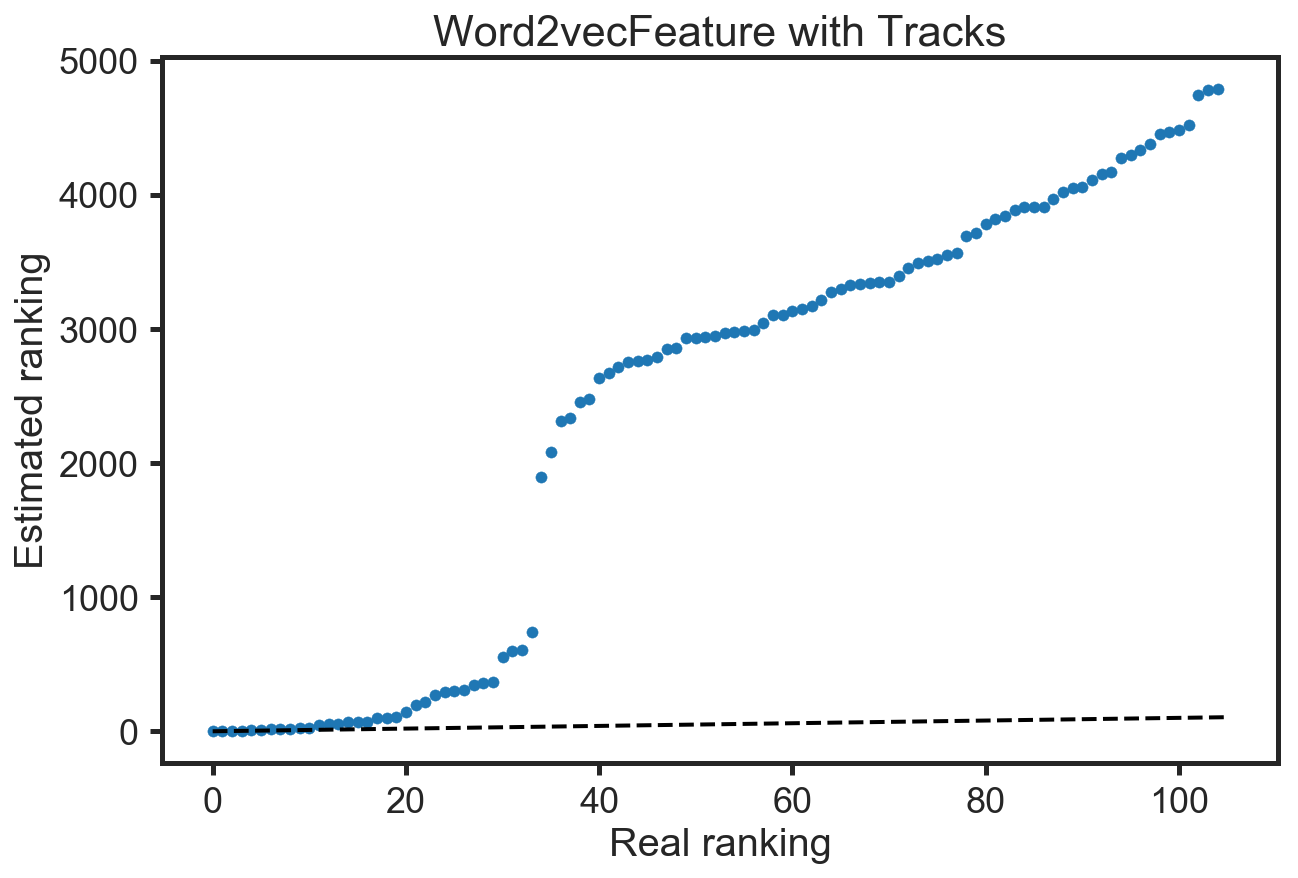

In [22]:
f_name= f.__class__.__name__
ranked_plots(turi_pool,turi_true,turi_ranked,dist,f_name,'Tracks')

# One playlist vs several features

In [23]:
# select a feature
k=25
n_picks=5000
pid=194
strat='mean'
weights= [1 for f in feats]
# rankign based on distances
turi_seed,auri_seed, turi_true,auri_true, turi_pool,auri_pool = tracks.get_playlist_pooltest(pid=pid,k=k,n=n_picks)
# get scaled distance
dist = np.zeros(len(turi_pool))
for f,w in zip(feats,weights):
    dist= dist + w*f.distance_between_sets(turi_seed,turi_pool,strat)
# rank based on 
sorted_indx=np.argsort(dist)
turi_ranked = [turi_pool[i] for i in sorted_indx]
auri_ranked = [auri_pool[i] for i in sorted_indx]
stats = ranking_stats(pid,k,strat,n_picks,turi_true,turi_pool,auri_true,auri_pool)
stats['rprecision_tracks']

(25, 9)
(5000, 9)


0.01904761904761905

# Bayesopt the weights and startegies

### FIX RANDOM SEED

In [24]:
np.random.seed(0) 

## Setup optimization parameter space


In [25]:
domains=[]
strats = ['mean','split']
strat_dom = tuple(list([i for i,x in enumerate(strats)]))
for f in feats:
    f_name = f.__class__.__name__
    domains.append({'name':'{}_weight'.format(f_name), 'type': 'continuous', 'domain': (0.,50.0)})
    #domains.append({'name':'{}_strat'.format(f_name), 'type': 'categorical', 'domain': strat_dom,'dimensionality': 1})
domains

print ("FINISHED")

FINISHED


In [29]:
verbose=True
iter_n=0
def rprecision_eval(x):
    global iter_n
    #print(x[0])
    k=25
    n_picks=10000
    subset=500
    strat='mean'
    weights = [x[0][indx] for indx,i in enumerate(x[0])]
    stats=[]
    n_pids =100
    pids = [i for i in np.random.randint(0,5000,n_pids)]
    for pid in pids:
        turi_seed,auri_seed, turi_true,auri_true, turi_pool,auri_pool = tracks.get_playlist_pooltest(pid=pid,k=k,n=n_picks)
        if len(turi_true) > 0:
            # get scaled distance
            dist = np.zeros(len(turi_pool))
            for f,w in zip(feats,weights):
                dist= dist + w*f.distance_between_sets(turi_seed,turi_pool,strat)
            # rank based on distance
            sorted_indx=np.argsort(dist)
            turi_ranked = [turi_pool[i] for i in sorted_indx][:subset]
            auri_ranked = [auri_pool[i] for i in sorted_indx][:subset]
            # get starts
            stats.append(ranking_stats(pid,k,strat,n_picks,turi_true,turi_ranked,auri_true,auri_ranked))
    stats_df = pd.DataFrame(stats)
    # we wish to minize
    objective  = 1.0-np.mean(stats_df['rprecision_tracks'].values)
    #
    if verbose:
        print('{}: r-precision of {:.3f}'.format(iter_n,1-objective))
        print('\t {}'.format(str(['{:2.3f}'.format(w) for w in  weights])))
        iter_n+=1
    
    return objective
print ('finished')

finished


In [30]:
bopt = GPyOpt.methods.BayesianOptimization(f=rprecision_eval,                     # Objective function       
                                             domain=domains,          # Box-constraints of the problem
                                             initial_design_numdata = 5,   # Number data initial design
                                             acquisition_type='EI',        # Expected Improvement
                                             exact_feval = True)           # True evaluations, no sample noise

print ('finished')

0: r-precision of 0.145
	 ['36.920', '17.439', '35.454', '18.916', '48.979']
1: r-precision of 0.173
	 ['27.768', '1.231', '30.587', '5.002', '7.424']
2: r-precision of 0.092
	 ['10.076', '7.441', '33.595', '48.013', '12.935']
3: r-precision of 0.157
	 ['27.426', '6.593', '22.376', '3.622', '10.776']
4: r-precision of 0.146
	 ['25.982', '35.396', '34.804', '0.965', '28.996']
finished


In [ ]:
max_iter=100
bopt.run_optimization(max_iter,eps=0)

In [ ]:
bopt.plot_convergence()